In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

2025-11-25 18:26:12.037167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764116772.055271  162199 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764116772.060653  162199 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764116772.074303  162199 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764116772.074330  162199 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764116772.074332  162199 computation_placer.cc:177] computation placer alr

# Dataset MNIST

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # [N,28,28,1]
x_test = np.expand_dims(x_test, -1)


In [23]:
x_train.shape

(60000, 28, 28, 1)

In [3]:
value_counts = Counter(y_train)
print(value_counts)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [4]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [5]:
i = 15
img = x_train[i]

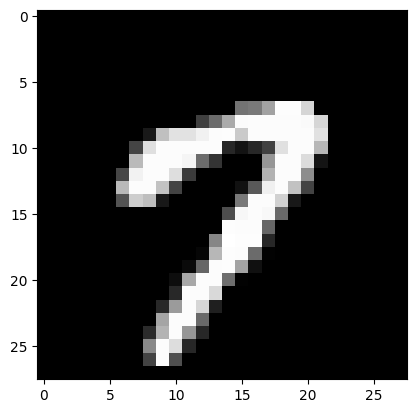

In [6]:
plt.imshow(img, cmap="gray")

In [7]:
y_train[i]

7

# Operaciones en una CNN

## 1. Convolución

**Qué hace:**
Proceso donde un *filtro* (o *kernel*) pequeño —por ejemplo de tamaño 3×3— se desliza sobre la imagen y calcula una combinación ponderada (multiplicación y suma) de los píxeles bajo él.

**Ejemplo:**
Si tienes una imagen de 5×5 píxeles y aplicas un filtro 3×3, en cada posición el filtro toma una pequeña porción (3×3) de la imagen, multiplica cada valor por el peso correspondiente del filtro y suma todos esos valores → ese resultado es **un nuevo píxel** de la imagen salida (el *mapa de características*).

**Intuición:**
Cada filtro aprende a detectar un patrón visual: bordes, texturas, esquinas, etc.

---

## 2. Padding (relleno)

Cuando aplicas una convolución, la imagen se "encoge" (por ejemplo, una imagen 5×5 con filtro 3×3 produce una salida de 3×3).
**Padding** sirve para *rellenar los bordes* de la imagen con ceros (u otros valores), evitando esa reducción.

**Tipos comunes:**

* `"valid"` → sin padding, la salida se reduce.
* `"same"` → se añade el padding necesario para que la salida tenga el mismo tamaño que la entrada.

**Intuición:**
Padding evita perder información de los bordes y mantiene la resolución.

---

## 3. Stride (paso)

El **stride** indica *cuánto se mueve el filtro* en cada paso cuando se desliza sobre la imagen.

**Ejemplo:**

* Stride = 1 → el filtro se mueve 1 píxel a la vez (superposición máxima, salida grande).
* Stride = 2 → se mueve 2 píxeles (menos superposición, salida más pequeña).

**Intuición:**
Stride controla la *resolución espacial* de la salida. Cuanto mayor el stride, más compresión espacial (y menor coste computacional).

---

## 4. Pooling

**Pooling** reduce el tamaño espacial de los mapas de características, conservando la información más importante.

**Tipos comunes:**

* **MaxPooling:** toma el valor máximo dentro de una ventana (ej. 2×2).
* **AveragePooling:** toma el promedio.

**GlobalMaxPooling:** toma el máximo de *toda* la característica (por canal), reduciendo el mapa completo a un solo valor por canal.

**Intuición:**
Pooling resume regiones locales → hace la red más robusta a pequeñas traslaciones o distorsiones.

---

* La convolución detecta patrones.
* El padding mantiene dimensiones.
* El stride controla la velocidad de desplazamiento del filtro.
* El pooling reduce y resume la información.



# CNN model

In [8]:
inputs = tf.keras.Input(shape=(28,28,1))
x = tf.keras.layers.Conv2D(8, (3,3), activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

I0000 00:00:1764116775.407314  162199 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13636 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:07:00.0, compute capability: 8.9


# Training

In [9]:
model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.1)

Epoch 1/20


I0000 00:00:1764116777.224244  162353 service.cc:152] XLA service 0x73d894002470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764116777.224274  162353 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-11-25 18:26:17.252892: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764116777.380978  162353 cuda_dnn.cc:529] Loaded cuDNN version 91001


 68/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4734 - loss: 1.6995

I0000 00:00:1764116779.501728  162353 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7656 - loss: 0.8033 - val_accuracy: 0.9492 - val_loss: 0.1819
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9402 - loss: 0.2003 - val_accuracy: 0.9650 - val_loss: 0.1248
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9598 - loss: 0.1339 - val_accuracy: 0.9725 - val_loss: 0.0999
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9669 - loss: 0.1105 - val_accuracy: 0.9753 - val_loss: 0.0868
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9735 - loss: 0.0895 - val_accuracy: 0.9808 - val_loss: 0.0777
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9799 - loss: 0.0691 - val_accuracy: 0.9805 - val_loss: 0.0712
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9827 - loss: 0.0606 - val_accuracy: 0.9828 - val_loss: 0.0684
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9836 - loss: 0.0567 - val_accuracy: 0.9830 - val_

In [26]:
img = x_test[0:1]
img.shape

(1, 28, 28, 1)

In [27]:
model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([[2.5936106e-10, 8.1161716e-11, 1.4167816e-05, 1.1609982e-06,
        2.4655178e-13, 2.4586672e-12, 8.9959650e-17, 9.9998450e-01,
        2.4052056e-08, 4.4441730e-08]], dtype=float32)

In [11]:
np.argmax(model.predict(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


7

In [12]:
y_test[0]

7

# Extraemos filtros de la primera capa

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        43,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,120 (512.19 KB)

 Trainable params: 43,706 (170.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 87,414 (341.46 KB)

In [13]:
filters, biases = model.layers[1].get_weights()
print("Forma de los filtros:", filters.shape)

Forma de los filtros: (3, 3, 1, 8)


In [14]:
filters[:,:, 0, 0]

array([[-1.151158  , -0.8351064 ,  0.5965793 ],
       [-1.0373311 ,  0.1023084 ,  0.9496686 ],
       [-0.53292584,  0.55726725,  0.5360528 ]], dtype=float32)

# Visualizamos filtros y sus FFT

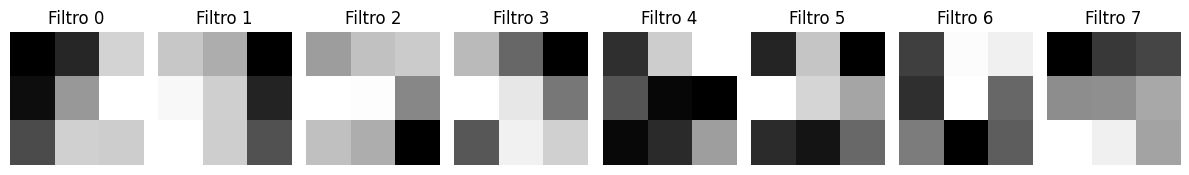

In [15]:
plt.figure(figsize=(12,6))
for i in range(filters.shape[-1]):  # cada filtro
    f = filters[:, :, 0, i]

    # Plot filtro
    plt.subplot(2, filters.shape[-1], i+1)
    plt.imshow(f, cmap="gray")
    plt.axis("off")
    plt.title(f"Filtro {i}")

plt.tight_layout()
plt.show()


# Ejemplo de una convolución con una imagen

In [16]:
img = x_test[0:1]

In [34]:
first_layer = model.layers[1]
first_layer.output

<KerasTensor shape=(None, 26, 26, 8), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>

In [17]:
activation_model = tf.keras.Model(inputs=model.input,
                                  outputs=first_layer.output)

activations = activation_model.predict(img)

activations.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


(1, 26, 26, 8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Forma de la activación: (1, 26, 26, 8)


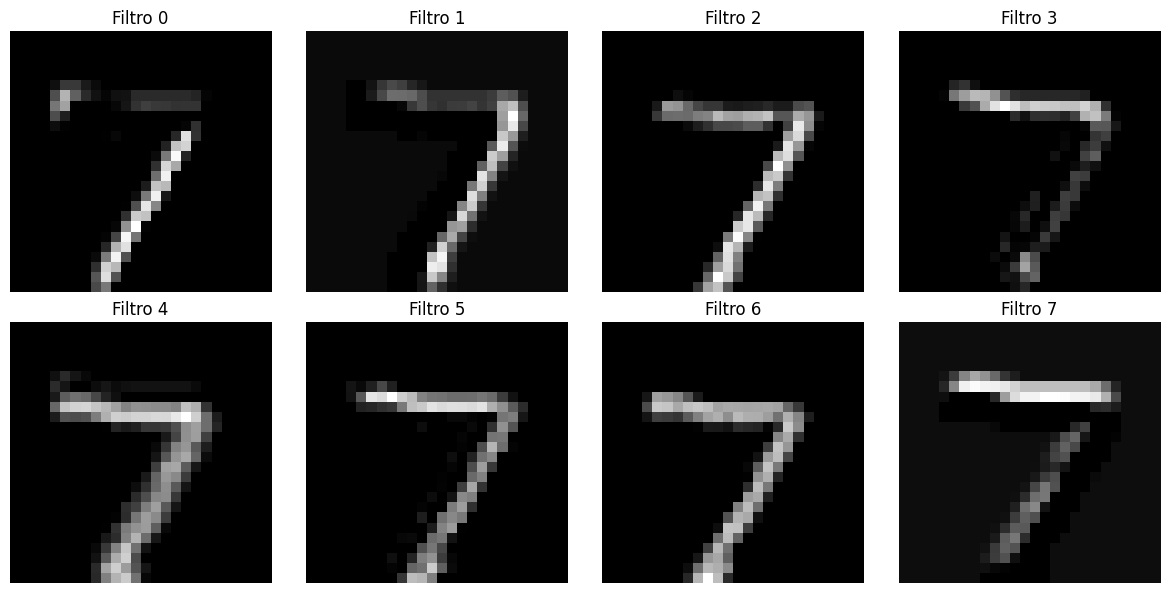

In [18]:
activations = activation_model.predict(img)

print("Forma de la activación:", activations.shape)

plt.figure(figsize=(12,6))
for i in range(activations.shape[-1]):
    plt.subplot(2, 4, i+1)
    plt.imshow(activations[0,:,:,i], cmap="gray")
    plt.axis("off")
    plt.title(f"Filtro {i}")

plt.tight_layout()
plt.show()

In [19]:
activations.shape

(1, 26, 26, 8)

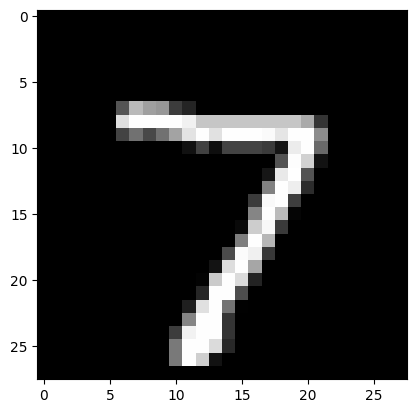

In [20]:
plt.imshow(img[0], cmap="gray")